In [15]:
import imageio.v3 as io
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

im = io.imread('imageio:coins.png')
print(im.shape)

# CONSTANTS FOR 8X8 FILTER
M = 8
N = 8

padding_bottom = (M - im.shape[0] % M) if (im.shape[0] % M) != 0 else 0
padding_right = (N - im.shape[1] % N) if (im.shape[1] % N) != 0 else 0

im = np.array(im)
im = np.pad(im, ((0, padding_bottom), (0, padding_right)), 'constant', constant_values=(0,0))
print(im.shape)

(303, 384)
(304, 384)


In [16]:
print(im)

[[ 47 123 133 ...  14   3  12]
 [ 93 144 145 ...  12   7   7]
 [126 147 143 ...   2  13   3]
 ...
 [ 88  82  74 ...   5   7   8]
 [ 91  79  68 ...   4  10   7]
 [  0   0   0 ...   0   0   0]]


In [17]:
class im_processing:
    def __init__(self, M, N):
        self.M = M
        self.N = N
        self.tot_row = 0
        self.tot_col = 0
        self.tot_mat = 0
        
    def split_into_dimension(self, img):
        self.tot_row = int(img.shape[0] /self.M)
        self.tot_col = int(img.shape[1] / self.N)
        self.tot_mat = int((img.shape[0] * img.shape[1]) / (self.M * self.N))
        split = []
        for i in range(0, self.tot_row):
            for j in range(0, self.tot_col):
                temp = np.zeros((self.M, self.N))
                for ii in range(0, self.M):
                    for jj in range(0, self.N):
                        temp[ii][jj] = img[i * self.M + ii][j * self.N + jj]
                split.append(temp)
        split = np.array(split)
        split = split.reshape((self.tot_row, self.tot_col, self.M, self.N))
        return split
    
    def merge_into_one(self, splits):
        img = []
        for i in range(0, self.tot_row):
            for ii in range(0, self.M):
                temp = []
                for j in range(0, self.tot_col):
                    for jj in range(0, self.N):
                        temp.append(splits[i][j][ii][jj])
                img.append(temp)
        img = np.array(img)
        return img
        

(38, 48, 8, 8)
[[ 47. 123. 133. ...  14.   3.  12.]
 [ 93. 144. 145. ...  12.   7.   7.]
 [126. 147. 143. ...   2.  13.   3.]
 ...
 [ 88.  82.  74. ...   5.   7.   8.]
 [ 91.  79.  68. ...   4.  10.   7.]
 [  0.   0.   0. ...   0.   0.   0.]]


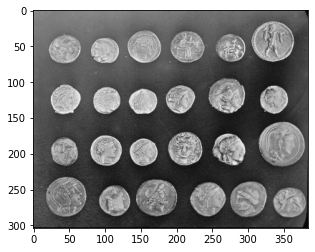

In [18]:
preprocess = im_processing(M,N)
splits = preprocess.split_into_dimension(im)
print(splits.shape)
img = preprocess.merge_into_one(splits)
print(img)
plt.imshow(img, cmap='gray')

In [19]:
class DCT2:
    def __init__(self, M, N):
        self.M = M
        self.N = N
        self.dct_basis = np.zeros((self.M, self.N, self.M, self.N))
        
    def compute_basis_dct_coefficients(self):
        for p in range(0, self.M):
            for q in range(0, self.N):
                for x in range(0, self.M):
                    for y in range(0, self.N):
                        self.dct_basis[p][q][x][y] += self.compute_basis_dct(p, q, x, y)
    
    def compute_basis_dct(self, p, q, x, y):
        alpha_p = 0
        alpha_q = 0
        if (p == 0):
            alpha_p = 1 / math.sqrt(self.M)
        else:
            alpha_p = math.sqrt(2 / self.M)
        if (q == 0):
            alpha_q = 1 / math.sqrt(self.N)
        else:
            alpha_q = math.sqrt(2 / self.N)
        dct = (alpha_p 
                * alpha_q
                * math.cos((math.pi * (2 * x + 1) * p) / (2 * self.M)) 
                * math.cos((math.pi * (2 * y + 1) * q) / (2 * self.N)))
        return dct
    
    def compute_dct2(self, im_seg):
        F = np.ones((self.M, self.N))
        for p in range(0, self.M):
            for q in range(0, self.N):
                f = 0
                for x in range(0, self.M):
                    for y in range(0, self.N):
                        f += self.dct_basis[p][q][x][y] * im_seg[x][y]
                F[p][q] = f
        return F
    
    def compute_inverse_dct2(self, F):
        F_inv = np.zeros((self.M, self.N))
        for x in range(0, self.M):
            for y in range(0, self.N):
                f = 0
                for p in range(0, self.M):
                    for q in range(0, self.N):
                        f += self.dct_basis[p][q][x][y] * F[p][q]
                F_inv[x][y] = f
        return F_inv
    
    def apply_filter(self, img, filter_matrix):
        filtered_img = np.multiply(img, filter_matrix)
        return filtered_img
    
    def get_filter(self, mode, diag = 8):
        if mode == 'lossless':
            filter_matrix = np.ones((self.M, self.N))
        else:
            filter_matrix = np.zeros((self.M, self.N))
            for i in range(0, diag):
                for j in range(0, diag - i):
                    filter_matrix[i][j] = 1
        return filter_matrix
        

In [20]:
test = DCT2(M,N)
test.compute_basis_dct_coefficients()
# filter_matrix = np.ones((8,8))
filter_matrix = test.get_filter(mode='lossy', diag = 4)

In [21]:
print(filter_matrix)

[[1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [22]:
segments = []
for i in range(0, splits.shape[0]):
    for j in range(0, splits.shape[1]):
        temp = test.compute_dct2(splits[i][j])
        temp = test.apply_filter(temp, filter_matrix)
        segments.append(temp)

In [23]:
segments = np.array(segments)
segments = segments.reshape((int(im.shape[0] / M),int(im.shape[1] / N),M,N))
print(segments.shape)

(38, 48, 8, 8)


In [24]:
image = preprocess.merge_into_one(segments)

True

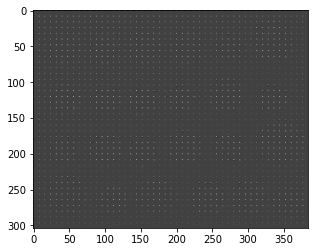

In [25]:
plt.imshow(image, cmap='gray')
cv2.imwrite('intermediate.png', image)

In [26]:
image = io.imread('intermediate.png')

In [27]:
inv_segments = []
for i in range(0, segments.shape[0]):
    for j in range(0, segments.shape[1]):
        temp = test.compute_inverse_dct2(segments[i][j])
        inv_segments.append(temp)
inv_segments = np.array(inv_segments)
inv_segments = inv_segments.reshape((int(im.shape[0] / M),int(im.shape[1] / N),M,N))
decompressed_image = preprocess.merge_into_one(inv_segments)

(303, 384)


True

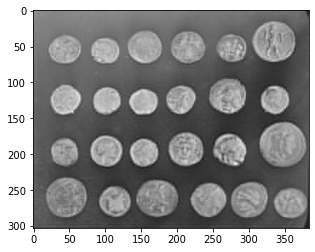

In [34]:
decompressed_img = decompressed_image[0:-1 * padding_bottom,0:-1 * padding_right if padding_right != 0 else im.shape[1]]
print(decompressed_img.shape)
plt.imshow(decompressed_img, cmap='gray')
cv2.imwrite('output1.png', decompressed_img)

In [19]:
#COMPAING SIZE OF FILES
import os

inp_file = 'testing.png'
int_file = 'intermediate.png'
out_file = 'output.png'

print(f'{inp_file} size : {os.stat(inp_file).st_size} bytes')
print(f'{int_file} size : {os.stat(int_file).st_size} bytes')
print(f'{out_file} size : {os.stat(out_file).st_size} bytes')

testing.png size : 77558 bytes
intermediate.png size : 19584 bytes
output.png size : 68057 bytes
